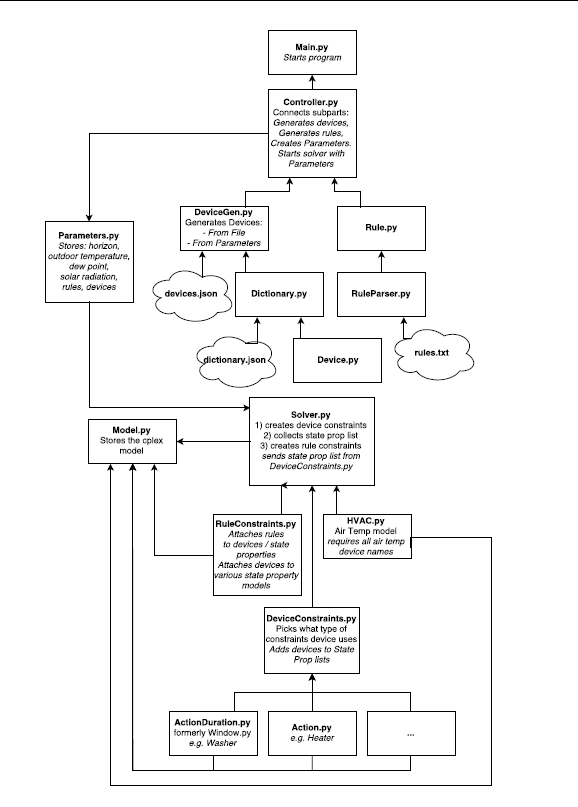

In [10]:
from IPython.display import Image
Image(filename='C:/Users/wklue/Desktop/SHS/resources/doc/SHS_structure.png')

Device Schedule

All of the examples in this notebook use the following rules for a washer and dryer:

GE_WSM2420D3WW  regular_w  before  11

GE_WSM2420D3WW  regular_d  before   8

Below is an example of:
  1. Creating Devices
  2. Creating Rules
  3. Running Solver

In [2]:
import src.Parameters as Parameters
import src.Reader as Reader
import src.Solver as Solver

params = Parameters.Parameters(fname='C:/Users/wklue/Desktop/SHS/resources/input/rules.txt')
horizon = params.horizon

# Location of the folder holding the JSON file defining the Device dictionary
filename = 'C:/Users/wklue/Desktop/SHS/resources/input'
reader = Reader.Reader(fname=filename)


# Finding the dictionary of devices
# get_dictionary() returns a Dictionary object (defined in Dictionary.py)
dictionary = reader.get_dictionary()

# Finding each device by using the dictionary
devices = [
    dictionary.get_device(device_type='washer', device_name='GE_WSM2420D3WW', mode_name="regular_w", dID=0),
    dictionary.get_device(device_type= 'dryer', device_name='GE_WSM2420D3WW', mode_name="regular_d", dID=1)
]

# Loading in devices
params.devices = devices

# Starting up solver with Parameters
solver = Solver.Solver(params=params)

# Setting up a dependency between the washer and dryer
solver.dependancy(devices[0], devices[1])
solution = solver.solve()

print('____ Price Schema ____________________________________________')
for p in params.price_schema:
    if p < 10:
        print(p, end='  ')
    else:
        print(p, end=' ')
print()

print('____ Devices ________________________________________________')
for d in devices:
    print(d.get_info(), end='')
    

print('____ Rules __________________________________________________')
for r in params.rules:
    r.print_rule()
    
# solution if normal rule is used
if devices is None:
    devices = []

print('____ Schedule _______________________________________________')
for d in range(len(devices)):
    print('Device', devices[d].name + ':')
    for p in range(len(devices[d].phases)):
        print(devices[d].mode[p]['name'] + ':', end='\t')
        for t in range(params.horizon):
            print(int(solution.get_values('d' + str(d) + '_p' + str(p) + '_' + str(t))), end=' ')
        print()
    print('___________________________________________________________')

____ Price Schema ____________________________________________
40 35 30 30 28 25 25 25 22 22 20 20 16 16 12 12 10 8  8  8  6  6  4  2  
____ Devices ________________________________________________
GE_WSM2420D3WW	d0	regular_w
GE_WSM2420D3WW	d1	regular_d
____ Rules __________________________________________________
GE_WSM2420D3WW  regular_w  before  17
GE_WSM2420D3WW  regular_d  before  18
____ Schedule _______________________________________________
Device d0:
wash:	0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 
spin:	0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 
rinse:	0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 
___________________________________________________________
Device d1:
dry:	0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 
___________________________________________________________


Solver

This code chunk shows the initial variables getting created for objPrice (cost of the schedule) as well as the variables for each timestep's kWh usage:

In [6]:
import src.Model
import src.HVAC
import src.DeviceConstraints as DCons
import src.RuleConstraints as RCons
import cplex
import src.Parameters
import src.Reader

class Solver:

    def __init__(self, params):
        self.params = params
        self.horizon = params.horizon
        self.rules = params.rules
        self.devices = params.devices

        self.model = src.Model.Model().model
        
        # Device Constraints
        # Chooses the type of constraints for each device and sets up the variables --
        #              -- for each device that will be used to set rules and calculate kWh usage
        dcons = DCons.DeviceConstraints(model=self.model, params=self.params, devices=self.devices)
        
        # Rule Constraints
        # For each rule, locates the devices associated to the rule and adds rule constraints
        rcons = RCons.RuleConstraints(model=self.model, mode_cons=dcons.mode_cons, rules=self.rules)
        self.rule_pref = rcons.rule_pref
        
        # Creating variables
        self.model.variables.add(
            names=['objPrice'],
            types=[self.model.variables.type.continuous],
            lb=[0.0]
        )

        self.model.variables.add(
            names=['s_' + str(t) for t in range(self.horizon)],
            types=[self.model.variables.type.continuous] * self.horizon,
            lb=[0.0] * self.horizon,
            obj=params.price_schema
        )
        
        # Setting constraints
        self.vars = dcons.vars
        val = []
        for v in range(len(self.vars[0])):
            val.append(1.0)

        values = [-1.0]
        values.extend(val)
        for t in range(self.horizon):
            indices = ['s_' + str(t)]

            indices.extend(self.vars[t])
            self.model.linear_constraints.add(
                lin_expr=[
                    cplex.SparsePair(
                        ind=indices,
                        val=values
                    )
                ],
                senses=['E'],
                rhs=[0.0]
            )

        # obj price = (s_0 * price_schema_0) + ... + (s_H * price_schema_H)
        _ind = ['objPrice']
        _val = [-1.0]
        for t in range(self.horizon):
            _ind.append('s_' + str(t))
            _val.append(params.price_schema[t])
        self.model.linear_constraints.add(
            lin_expr=[
                cplex.SparsePair(
                    ind=_ind,
                    val=_val
                )
            ],
            senses=['E'],
            rhs=[0.0]
        )

        self.model.parameters.solutiontarget = 2
        self.model.objective.set_sense(self.model.objective.sense.minimize)

Bayesian Optimization

This is an example of the same as above but with bayesian optimization.
The target function is used to test variables t = x_1, x_2, x_3, ... and find a y value. The Gaussian Process is then updated with the result.

In [3]:
import src.Parameters as Parameters
import src.Reader as Reader
import src.Solver as Solver
import src.Expectation as expectation
from src.bayes_opt.bayesian_optimization import BayesianOptimization as bayesian


filename = 'C:/Users/wklue/Desktop/SHS/resources/input'
reader = Reader.Reader(fname=filename)

params = Parameters.Parameters(fname='C:/Users/wklue/Desktop/SHS/resources/input/rules.txt')
horizon = params.horizon

# TODO: handle 'within', 'at' rules
t_vals = []
for r in params.rules:
    print(r.time1, r.time2)
    if r.time1 == 0:  # before
        t_vals.append((r.time2, horizon-1))
    elif r.time2 == horizon:  # after
        t_vals.append((0, r.time1))
    else:
        print('ERROR: unhandled rule:')
        print(r.to_string())
pbounds = {'t': t_vals}
print(pbounds)
solver = Solver.Solver(params=params)

# the user expectation "black box" is generated from selecting random values between the following:
expect_vals = [[0, 600], [0, 1600]]
expect = expectation.Expectation(bounds=t_vals, expect=expect_vals)


def target_function(t):
    t = t.astype(int)
    for i in range(len(t)):
        if t[i] < params.rules[i].time1:
            params.rules[i].time1 = t[i]
        else:
            params.rules[i].time2 = t[i]
        # print(params.rules[i].to_string())
    check = solver.reset(params=params)
    if check == -1:
        return -32768  # return a large negative number if rules inconsistent

    solver.dependancy(params.devices[0], params.devices[1])
    solution = solver.solve()

    if params.verbose:
        print('=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+')
        print('SOLUTION STATUS:', solution.get_status())
        print('objPrice Value:', solution.get_values('objPrice'))
        print('=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+')

    if solution.get_status() != 103:  # if solution status is 101, optimal solution found --- 103 means infeasible (hoping this works -- will require more experimentation)
        return round(expect.get_value(t) - solution.get_values('objPrice') + params.reg_price, 2)
    else:
        return -32768  # return a large negative number if solution is infeasible


dictionary = reader.get_dictionary()
devices = [
    dictionary.get_device(device_type='washer', device_name='GE_WSM2420D3WW', mode_name="regular_w", dID=0),
    dictionary.get_device(device_type= 'dryer', device_name='GE_WSM2420D3WW', mode_name="regular_d", dID=1)
]

params.devices = devices
solver.reset(params=params)
solver.dependancy(devices[0], devices[1])
# The objective value is found for the original rules before the Bayesian Optimization is run
# This value is used in the target function
solution = solver.solve()
reg_price = round(solution.get_values('objPrice'), 2)
params.reg_price = reg_price

# rule, horizon
bay = bayesian(f=target_function, pbounds=pbounds, verbose=0, random_state=1)
bay.maximize(n_iter=5)

0 17
0 18
{'t': [(17, 23), (18, 23)]}


________________________________________
Step    |    Value    |        t        |
0.  |         2036.0  |   [ 18.  19.]
________________________________________|


________________________________________
Step    |    Value    |        t        |
1.  |         2036.0  |   [ 18.20601458  19.        ]
________________________________________|


________________________________________
Step    |    Value    |        t        |
2.  |         2050.0  |   [ 19.          19.50424471]
________________________________________|


________________________________________
Step    |    Value    |        t        |
3.  |         2036.0  |   [ 18.32218607  19.50383299]
________________________________________|


________________________________________
Step    |    Value    |        t        |
4.  |         2036.0  |   [ 18.8143123   19.66594101]
________________________________________|


Bayesian Optimization Maximize code had to be modified for our needs:

In [ ]:
from __future__ import print_function
from __future__ import division
from src.bayes_opt.helpers import (UtilityFunction, acq_max)
from src.bayes_opt.target_space import TargetSpace
import src.Bound as Bound

def maximize(self,
             init_points=5,
             n_iter=25,
             acq='ucb',
             kappa=2.576,
             xi=0.0,
             **gp_params):
    """
    Main optimization method.

    Parameters
    ----------
    :param init_points:
        Number of randomly chosen points to sample the
        target function before fitting the gp.

    :param n_iter:
        Total number of times the process is to repeated. Note that
        currently this methods does not have stopping criteria (due to a
        number of reasons), therefore the total number of points to be
        sampled must be specified.

    :param acq:
        Acquisition function to be used, defaults to Upper Confidence Bound.

    :param gp_params:
        Parameters to be passed to the Scikit-learn Gaussian Process object

    Returns
    -------
    :return: Nothing

    """
    # Reset timer
    self.plog.reset_timer()

    # Set acquisition function
    self.util = UtilityFunction(kind=acq, kappa=kappa, xi=xi)

    # Initialize x, y and find current y_max
    if not self.initialized:
        if self.verbose:
            self.plog.print_header()
        self.init(init_points)

    point_bounds = []

    LB = []
    UB = []
    for i in range(len(self.space.bounds)):
        LB.append(self.space.bounds[i][0])
        UB.append(self.space.bounds[i][1])
        point_bounds.append([])

    for point in self.init_points:
        for var in range(len(point)):
            point_bounds[var] = Bound.add_bound(LB[var], UB[var], point_bounds[var], point[var])

    y_max = self.space.Y.max()

    # Set parameters if any was passed
    self.gp.set_params(**gp_params)

    # Find unique rows of X to avoid GP from breaking
    self.gp.fit(self.space.X, self.space.Y)

    # Finding argmax of the acquisition function.
    x_max = acq_max(ac=self.util.utility,
                    gp=self.gp,
                    y_max=y_max,
                    bounds=self.space.bounds,
                    point_bounds=point_bounds,
                    random_state=self.random_state,
                    **self._acqkw)

    for var in range(len(x_max)):
        point_bounds[var] = Bound.add_bound(LB[var], UB[var], point_bounds[var], round(x_max[var]))

    # Iterative process of searching for the maximum. At each round the
    # most recent x and y values probed are added to the X and Y arrays
    # used to train the Gaussian Process. Next the maximum known value
    # of the target function is found and passed to the acq_max function.
    # The arg_max of the acquisition function is found and this will be
    # the next probed value of the target function in the next round.
    for i in range(n_iter):

        # Append most recently generated values to X and Y arrays
        y = self.space.observe_point(x_max)
        
        # Prints the current step
        print('________________________________________')
        print('Step    |    Value    |        t        |')
        print(str(i)+'.  |        ', y, ' |  ', x_max)
        print('________________________________________|')


        # Updating the GP.
        self.gp.fit(self.space.X, self.space.Y)

        # Update the best params seen so far
        self.res['max'] = self.space.max_point()
        self.res['all']['values'].append(y)
        self.res['all']['params'].append(dict(zip(self.space.keys, [x_max])))

        # Update maximum value to search for next probe point.
        if self.space.Y[-1] > y_max:
            y_max = self.space.Y[-1]

        # Maximize acquisition function to find next probing point
        x_max = acq_max(ac=self.util.utility,
                        gp=self.gp,
                        y_max=y_max,
                        bounds=self.space.bounds,
                        point_bounds=point_bounds,
                        random_state=self.random_state,
                        **self._acqkw)

        # Adds x_max to the bounds used to avoid selecting already selected points
        for var in range(len(x_max)):
            point_bounds[var] = Bound.add_bound(LB[var], UB[var], point_bounds[var], round(x_max[var]))
        # Keeps track of total number of iterations
        i += 1

The acquisition function selects the next point to try in the Gaussian Process based on the upper confidence bound. Because we are working with integer time steps, I created a method that updates a list of 'Bounds' to keep track of values that have already been tried.

In [4]:
def add_bound(LB, UB, point_bounds, point, verbose=0):
    assert(LB < UB)
    point = round(point)

    if LB == point:
        # if [LB+0.5, LB+1.5] is already in list, replace with [LB, LB+1.5]
        # else add to beginning of list, ensure bounds are not out of range
        if len(point_bounds) > 0 and point_bounds[0][0] == point + 0.5:
            point_bounds[0] = (LB, point_bounds[0][0])
        else:
            point_bounds.insert(0, (LB, point + 0.5))
    elif point == UB:
        # if [UB-1.5, UB-0.5] is already in list, replace with [UB-1.5, UB]
        # else add to end of line, ensure bounds are not out of range
        if len(point_bounds) > 0 and point_bounds[len(point_bounds)-1][1] == point - 0.5:
            point_bounds[len(point_bounds) - 1] = (point_bounds[len(point_bounds) - 1][0], UB)
        else:
            point_bounds.insert(len(point_bounds), (point - 0.5, UB))
    else:  # find where new (lb, ub) belongs in sorted list point_bounds
        i = 0
        while True:
            if i >= len(point_bounds):
                # similar case to temp == UB, see above
                if len(point_bounds) > 0 and point_bounds[len(point_bounds) - 1][1] == point - 0.5:
                    point_bounds[len(point_bounds)-1] = (point_bounds[len(point_bounds)-1][0], point - 0.5)
                else:
                    point_bounds.insert(len(point_bounds), (point - 0.5, point + 0.5))
                break
            elif point_bounds[i][0] > point - 0.5:
                # if lower bounds of temp connects with a ub from list
                if point_bounds[i-1][1] == point - 0.5:
                    # if upper bounds of temp connects with a ub of list
                    if point_bounds[i][0] == point + 0.5:
                        point_bounds[i-1] = (point_bounds[i-1][0], point_bounds[i][1])
                        del point_bounds[i]
                    else:
                        point_bounds[i - 1] = (point_bounds[i-1][0], point + 0.5)
                else:
                    # if upper bounds of temp connects with a ub of list
                    if point_bounds[i][0] == point + 0.5:
                        point_bounds[i] = (point - 0.5, point_bounds[i][1])
                    else:  # most common case --- just add to list, maintaining sort
                        point_bounds.insert(i, (point - 0.5, point + 0.5))
                break
            i += 1
    if verbose == 1:
        print('adding', point)
        print('lb,ub:', point_bounds)
        print("----------------------------------------")
    return point_bounds

''' EXAMPLE: '''
LB, UB = 0, 100
temp = 0
point_bounds = []
temp_arr = [4, 0, 14, 12, 100, 85, 99, 97, 98, 15, 13, 1]

for element in temp_arr:
    point_bounds = add_bound(LB, UB, point_bounds, element, verbose=1)

adding 4
lb,ub: [(3.5, 4.5)]
----------------------------------------
adding 0
lb,ub: [(0, 0.5), (3.5, 4.5)]
----------------------------------------
adding 14
lb,ub: [(0, 0.5), (3.5, 4.5), (13.5, 14.5)]
----------------------------------------
adding 12
lb,ub: [(0, 0.5), (3.5, 4.5), (11.5, 12.5), (13.5, 14.5)]
----------------------------------------
adding 100
lb,ub: [(0, 0.5), (3.5, 4.5), (11.5, 12.5), (13.5, 14.5), (99.5, 100)]
----------------------------------------
adding 85
lb,ub: [(0, 0.5), (3.5, 4.5), (11.5, 12.5), (13.5, 14.5), (84.5, 85.5), (99.5, 100)]
----------------------------------------
adding 99
lb,ub: [(0, 0.5), (3.5, 4.5), (11.5, 12.5), (13.5, 14.5), (84.5, 85.5), (98.5, 100)]
----------------------------------------
adding 97
lb,ub: [(0, 0.5), (3.5, 4.5), (11.5, 12.5), (13.5, 14.5), (84.5, 85.5), (96.5, 97.5), (98.5, 100)]
----------------------------------------
adding 98
lb,ub: [(0, 0.5), (3.5, 4.5), (11.5, 12.5), (13.5, 14.5), (84.5, 85.5), (96.5, 100)]
------

Because we are sometimes working with more than one variable and this bounds list is only for one variable, we need a method to go through a 2D-array of "Bounds" iterating through every possible combination. Our "Bounds" lists are lists of areas we don't want to try points in so we have to take the lower bounds from one tuple and the upper bounds from another.

In [5]:
def selector(B, A=None):
    if A is None:
        A = [[]]

    A2 = []
    for a in A:
        for b in range(len(B[0])-1):
            A2.append(a + [b])

    if len(B) == 1:
        return A2
    else:
        return selector(B[1:], A2)


def select_bounds(A_x, i):
    lb = A_x[i][1]
    ub = A_x[i+1][0]
    return [lb, ub]


def get_bounds(B):
    A = selector(B)
    C = []
    for a in A:
        C.append([])
        for i in range(len(a)):
            C[len(C)-1].append(select_bounds(B[i], a[i]))

    return C

""" |B| = 4 """
''' EXAMPLE: '''
B = [
    [[ 1,  2], [ 3,  4], [ 5,  6]],
    [[ 7,  8], [ 9, 10], [11, 12], [13, 14], [15, 16]],
    [[17, 18], [19, 20], [21, 22], [23, 24]],
    [[25, 26], [27, 28]],
    ]

D = get_bounds(B)

print('Every possible iteration of lower and upper bound areas to try')
for d in D:
    print(d)

[[2, 3], [8, 9], [18, 19], [26, 27]]
[[2, 3], [8, 9], [20, 21], [26, 27]]
[[2, 3], [8, 9], [22, 23], [26, 27]]
[[2, 3], [10, 11], [18, 19], [26, 27]]
[[2, 3], [10, 11], [20, 21], [26, 27]]
[[2, 3], [10, 11], [22, 23], [26, 27]]
[[2, 3], [12, 13], [18, 19], [26, 27]]
[[2, 3], [12, 13], [20, 21], [26, 27]]
[[2, 3], [12, 13], [22, 23], [26, 27]]
[[2, 3], [14, 15], [18, 19], [26, 27]]
[[2, 3], [14, 15], [20, 21], [26, 27]]
[[2, 3], [14, 15], [22, 23], [26, 27]]
[[4, 5], [8, 9], [18, 19], [26, 27]]
[[4, 5], [8, 9], [20, 21], [26, 27]]
[[4, 5], [8, 9], [22, 23], [26, 27]]
[[4, 5], [10, 11], [18, 19], [26, 27]]
[[4, 5], [10, 11], [20, 21], [26, 27]]
[[4, 5], [10, 11], [22, 23], [26, 27]]
[[4, 5], [12, 13], [18, 19], [26, 27]]
[[4, 5], [12, 13], [20, 21], [26, 27]]
[[4, 5], [12, 13], [22, 23], [26, 27]]
[[4, 5], [14, 15], [18, 19], [26, 27]]
[[4, 5], [14, 15], [20, 21], [26, 27]]
[[4, 5], [14, 15], [22, 23], [26, 27]]


Acquisition Function:

In [ ]:
from __future__ import print_function
from __future__ import division
import numpy as np
from scipy.stats import norm
from scipy.optimize import minimize
from math import floor, ceil
from src.Selector import get_bounds


def acq_max(ac, gp, y_max, bounds, random_state, point_bounds=None, n_warmup=100000, n_iter=250):
    """
    A function to find the maximum of the acquisition function

    It uses a combination of random sampling (cheap) and the 'L-BFGS-B'
    optimization method. First by sampling `n_warmup` (1e5) points at random,
    and then running L-BFGS-B from `n_iter` (250) random starting points.

    Parameters
    ----------
    :param ac:
        The acquisition function object that return its point-wise value.

    :param gp:
        A gaussian process fitted to the relevant data.

    :param y_max:
        The current maximum known value of the target function.

    :param bounds:
        The variables bounds to limit the search of the acq max.

    :param point_bounds:
        ### Description by Bill --- Idea by Nando ###
        The boundaries for each point tried so far.
        If I tried points [ 3,  6,  100 ] and bounds are [0, 100]:
            point_bounds = [[2.5, 3.5], [5.5, 6.5], [99.5, 100]]

    :param random_state:
        instance of np.RandomState random number generator

    :param n_warmup:
        number of times to randomly sample the acquisition function

    :param n_iter:
        number of times to run scipy.minimize

    Returns
    -------
    :return: x_max, The arg max of the acquisition function.
    """

    if point_bounds is None:
        point_bounds = []
        for i in range(len(bounds)):
            point_bounds.append([])

    for i in range(len(point_bounds)):

        if len(point_bounds[i]) == 0:
            point_bounds[i].append((bounds[i][0], bounds[i][0]))
            point_bounds[i].append((bounds[i][1], bounds[i][1]))

        if point_bounds[i][0][0] != bounds[i][0]:
            point_bounds[i].insert(0, (bounds[i][0], bounds[i][0]))
        if point_bounds[i][len(point_bounds[i])-1][1] != bounds[i][1]:
            point_bounds[i].insert(len(point_bounds[i]), (bounds[i][1], bounds[i][1]))

    solutions = []
    # uses the function from above to format the points into an iterable list
    point_bounds = get_bounds(point_bounds)

    for b in point_bounds:
        bounds = np.array(b, dtype=np.float)
        # Warm up with random points
        x_tries = random_state.uniform(bounds[:, 0], bounds[:, 1], size=(n_warmup, bounds.shape[0]))
        ys = ac(x_tries, gp=gp, y_max=y_max)
        x_max = x_tries[ys.argmax()]
        max_acq = ys.max()

        # Explore the parameter space more thoroughly
        x_seeds = random_state.uniform(bounds[:, 0], bounds[:, 1], size=(n_iter, bounds.shape[0]))
        for x_try in x_seeds:
            # Find the minimum of minus the acquisition function
            res = minimize(lambda x: -ac(x.reshape(1, -1), gp=gp, y_max=y_max),
                           x_try.reshape(1, -1),
                           bounds=bounds,
                           method="L-BFGS-B")

            # Store it if better than previous minimum(maximum).
            if max_acq is None or -res.fun >= max_acq:
                x_max = res.x
                max_acq = -res.fun

        for i in range(len(x_max)):
            if floor(x_max[i]) == floor(bounds[i][0]):
                x_max[i] = ceil(x_max[i])
            elif ceil(x_max[i]) == ceil(bounds[i][1]):
                x_max[i] = floor(x_max[i])
        solutions.append((max_acq, x_max))
    
    # find the best solution's index
    sol_idx = np.argmax([x for x, y in solutions])
    # return the best solution
    return solutions[sol_idx][1]